In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set()

In [3]:
wd=os.getcwd()
wd

'C:\\Users\\iavta\\Time Series'

In [4]:
path_to_data=r"C:\Users\iavta\Time Series\R Datasets\Rdatasets-master\csv\datasets"

In [5]:
df=pd.read_csv(path_to_data+r"\EuStockMarkets.csv")

In [6]:
df.head()
# we need to remove first column

,Unnamed: 0,DAX,SMI,CAC,FTSE
0,1,1628.75,1678.1,1772.8,2443.6
1,2,1613.63,1688.5,1750.5,2460.2
2,3,1606.51,1678.6,1718.0,2448.2
3,4,1621.04,1684.1,1708.1,2470.4
4,5,1618.16,1686.6,1723.1,2484.7


In [7]:
df.drop(["Unnamed: 0"],axis=1, inplace=True)

Let's put a time index on this dataset!

According to [R Dataset Documentation](https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/EuStockMarkets), we know that the dataset comprises data collected daily, using business days, from 1991 to 1998.

In [8]:
time=pd.date_range("1991-07-01","1998-08-14",freq="B")
time
# from 1-7-1991 to 14-08-1998
# check dataset in R

DatetimeIndex(['1991-07-01', '1991-07-02', '1991-07-03', '1991-07-04',
               '1991-07-05', '1991-07-08', '1991-07-09', '1991-07-10',
               '1991-07-11', '1991-07-12',
               ...
               '1998-08-03', '1998-08-04', '1998-08-05', '1998-08-06',
               '1998-08-07', '1998-08-10', '1998-08-11', '1998-08-12',
               '1998-08-13', '1998-08-14'],
              dtype='datetime64[ns]', length=1860, freq='B')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAX     1860 non-null   float64
 1   SMI     1860 non-null   float64
 2   CAC     1860 non-null   float64
 3   FTSE    1860 non-null   float64
dtypes: float64(4)
memory usage: 58.2 KB


It seems strange that pandas doesn't allow to choose the country according to which we should remove the holidays. 

In [10]:
# Let's just include enough days, and assume that pandas counts them correctly.
df.index=time

In [11]:
df.head()

,DAX,SMI,CAC,FTSE
1991-07-01,1628.75,1678.1,1772.8,2443.6
1991-07-02,1613.63,1688.5,1750.5,2460.2
1991-07-03,1606.51,1678.6,1718.0,2448.2
1991-07-04,1621.04,1684.1,1708.1,2470.4
1991-07-05,1618.16,1686.6,1723.1,2484.7


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1860 entries, 1991-07-01 to 1998-08-14
Freq: B
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAX     1860 non-null   float64
 1   SMI     1860 non-null   float64
 2   CAC     1860 non-null   float64
 3   FTSE    1860 non-null   float64
dtypes: float64(4)
memory usage: 72.7 KB


In [13]:
df.to_csv(wd+"\\Data - Clean\\"+"EUStock_TimeIndex.csv", index = False)

## Plots

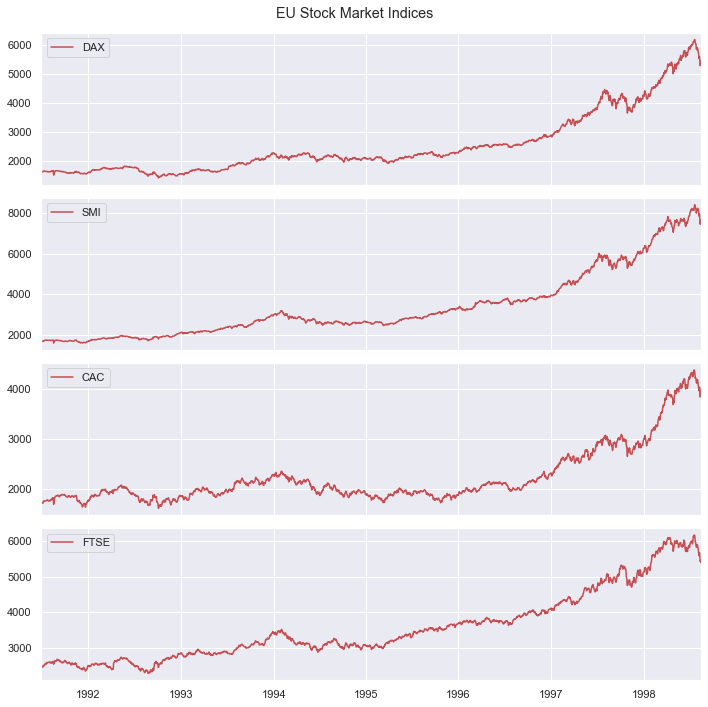

In [13]:
df.plot(kind='line', subplots=True, title="EU Stock Market Indices",
        layout=(4, 1), sharex=True, sharey=False, legend=True,    
        style=['r', 'r', 'r', 'r'], figsize=(10,10))
plt.tight_layout()
plt.show;

Clearly the data is not stationary. It has a trend, and volatility seems to increase as we approach the end of the series.

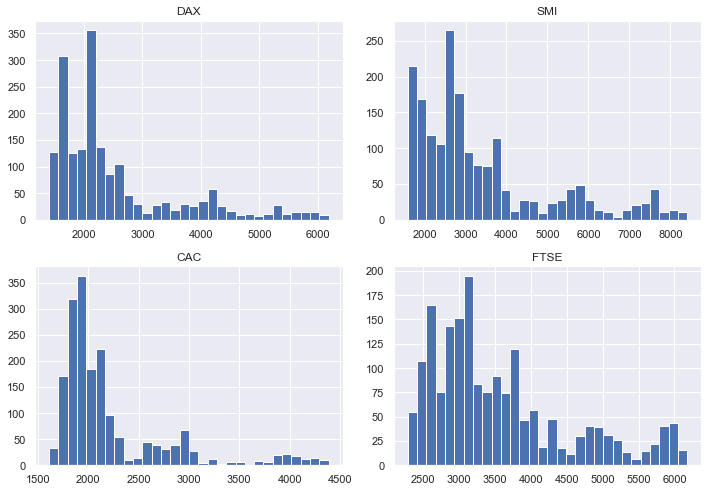

In [14]:
df.hist(bins=30,figsize=(10,7))
plt.tight_layout()
plt.show;

 #  Data Transformations

The objective of data transformations is to help us obtain a stationary time series.

## Differencing

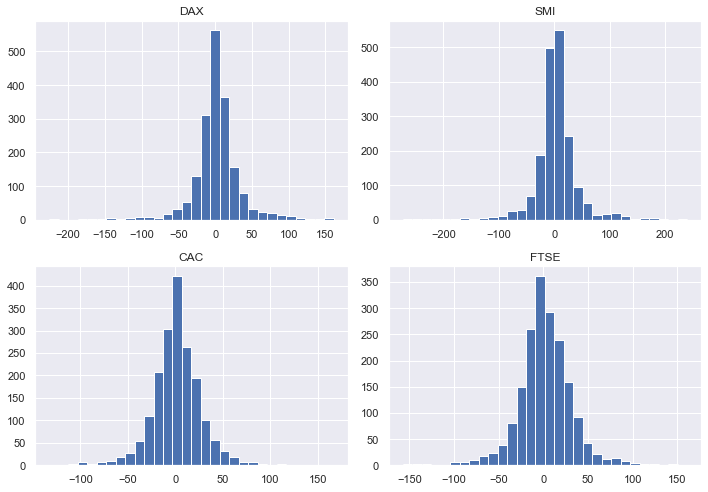

In [15]:
df_diffs=df.diff()
df_diffs.hist(bins=30,figsize=(10,7))
plt.tight_layout()
plt.show;


In [16]:
df_diffs.skew()

DAX    -0.329156
SMI    -0.387562
CAC     0.023912
FTSE   -0.105505
dtype: float64

A negative skew means that the left tail is longer, i.e. the mass of the distribution is concentrated on the right of the figure, which accounts for the overall increasing trend for the time series.

The close to zero positive skewness for the CAC is explained by its behaviour from 1991 to 1996, when it showed no clear growth trend.

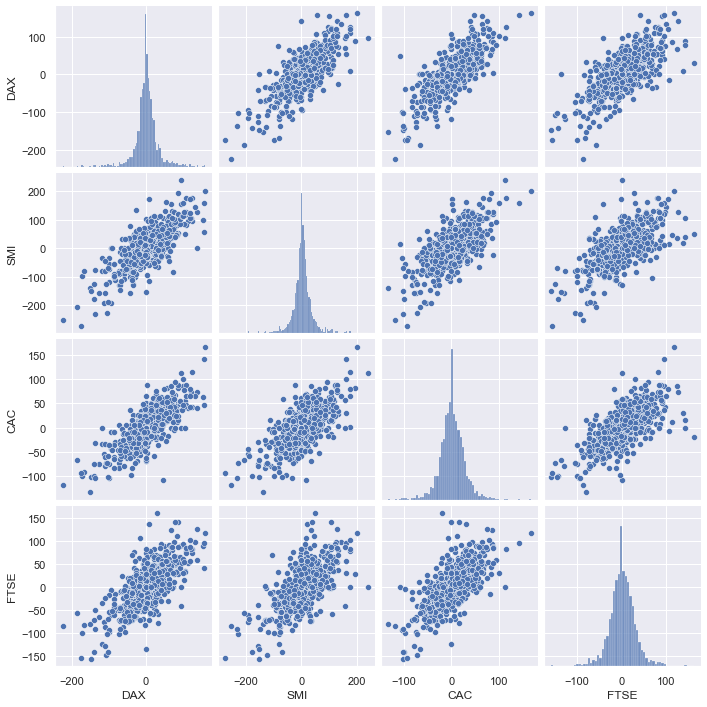

In [17]:
sns.pairplot(df_diffs);

These 'correlations' are those of same day. In reality, we use the past to predict either the present or the future. 

In [18]:
df_lagged=pd.DataFrame()
df_lagged["1lag_CAC"]=df_diffs["CAC"].shift(1)
df_lagged["2lag_SMI"]=df_diffs["SMI"].shift(2)
df_lagged["2lag_DAX"]=df_diffs["DAX"].shift(3)
df_lagged["FTSE"]=df_diffs["FTSE"]

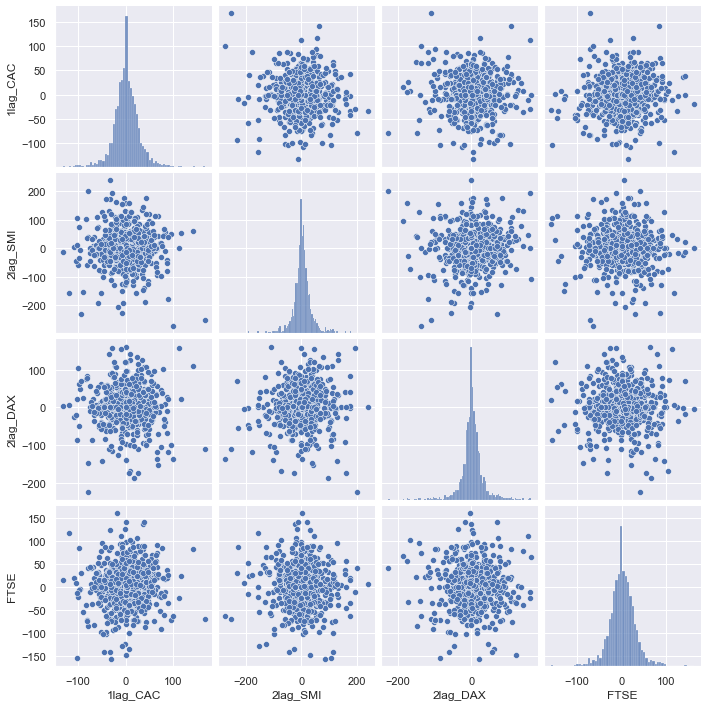

In [19]:
sns.pairplot(df_lagged);

## Moving Average (Or Trend-Cycle Estimation)

In [ ]:
df_mov_avg=pd.DataFrame()
window_size=7
for mkt_ind in df.columns.values:
    df_mov_avg[mkt_ind]= df[mkt_ind].rolling(window_size).mean()

If the seasonal period is even and of order $m$, we use a $2×m$-MA to estimate the trend-cycle.
If the seasonal period is odd and of order $m$, we use a $m$-MA to estimate the trend-cycle. 

Examples:

+ *Monthly* data with *annual seasonality* : $2×12$-MA.

+ *Daily* data with *weekly seasonality* : $7$-MA.

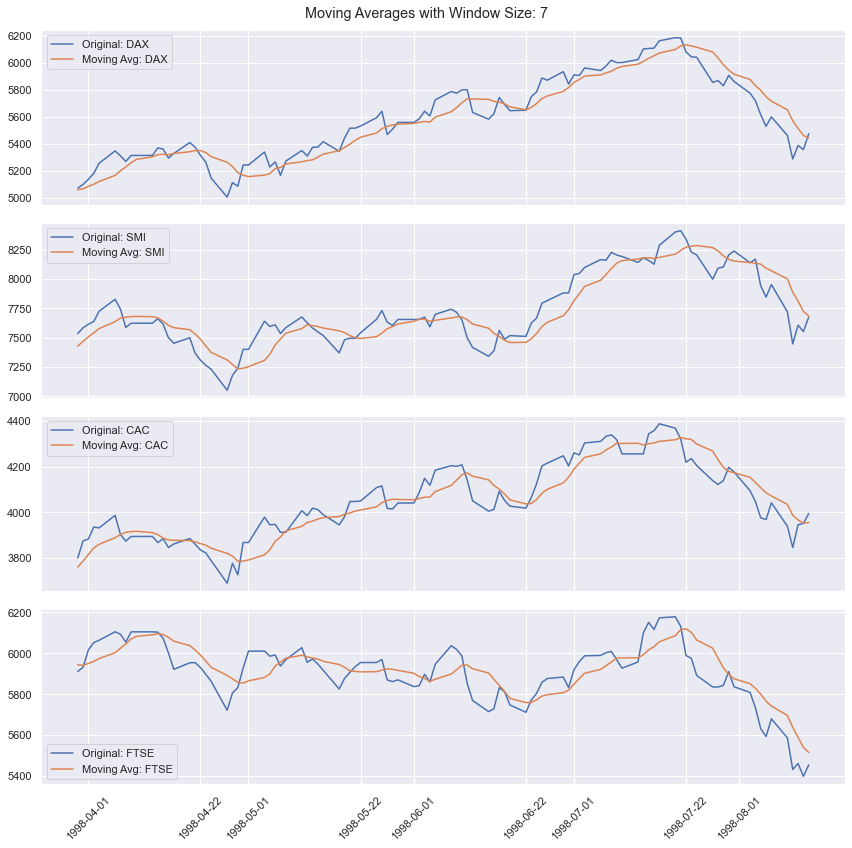

In [135]:
fig, axes = plt.subplots(4, 1, figsize=(12,12),sharex=True)

# If we include the complete time series we can't see very well the differences.
time_length=100
fig.suptitle('Moving Averages with Window Size: ' + str(window_size))
for i, mkt_ind in enumerate(df_mov_avg.columns.values):        
    ax = axes[i]
    line1, = ax.plot(df[mkt_ind][-time_length:], label='Original: '+mkt_ind)
    line2, = ax.plot(df_mov_avg[mkt_ind][-time_length:], label='Moving Avg: '+mkt_ind)
    ax.tick_params(axis="x", labelrotation=45)    
    ax.legend()
plt.tight_layout()
plt.show;

# Box-Cox Transformation

The objective of applying transformations such as differencing, logs, or the Box-Cox transformation is to help us transform the data into a stationary time series.

In [20]:
from scipy import stats

In [53]:
df_box_cox=pd.DataFrame()
dict_lambda={}

for mkt_ind in df.columns.values:
    Box_Cox_data, lambda_par =stats.boxcox(df[mkt_ind].values)
    df_box_cox[mkt_ind]= Box_Cox_data
    dict_lambda[mkt_ind]=lambda_par

In [54]:
df_box_cox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAX     1860 non-null   float64
 1   SMI     1860 non-null   float64
 2   CAC     1860 non-null   float64
 3   FTSE    1860 non-null   float64
dtypes: float64(4)
memory usage: 58.2 KB


In [55]:
df_box_cox.index=time

In [56]:
dict_lambda

{'DAX': -1.345183351229909,
 'SMI': -0.7059727098698431,
 'CAC': -3.3884970349148134,
 'FTSE': -1.2470458261762867}

A good lambda value makes the size of the seasonal variation about the same across the whole series.

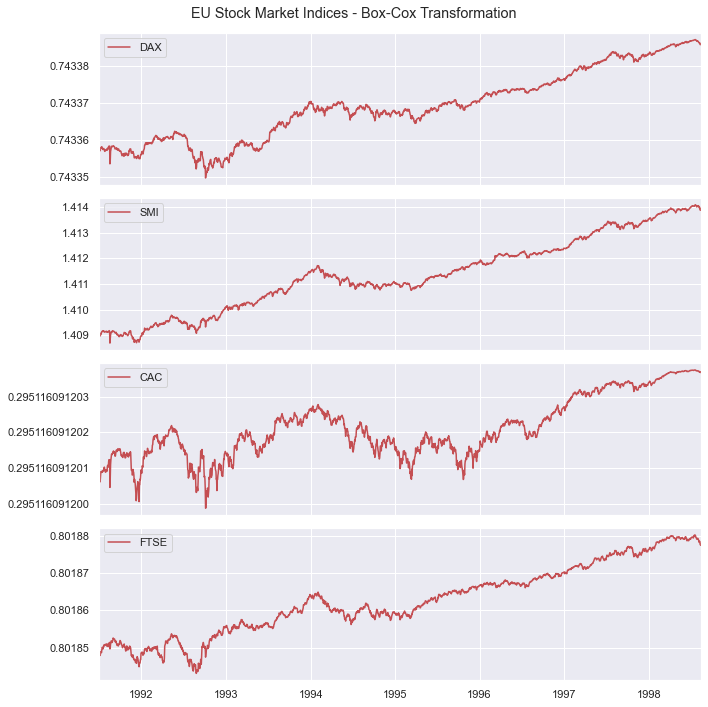

In [126]:
axes = df_box_cox.plot(kind='line', subplots=True,
                title="EU Stock Market Indices - Box-Cox Transformation",
        layout=(4, 1), sharex=True, sharey=False, legend=True,    
        style=['r', 'r', 'r', 'r'], figsize=(10,10))

for axis in axes:
    axis[0].ticklabel_format(axis='y', useOffset=False)
plt.tight_layout()
plt.show;

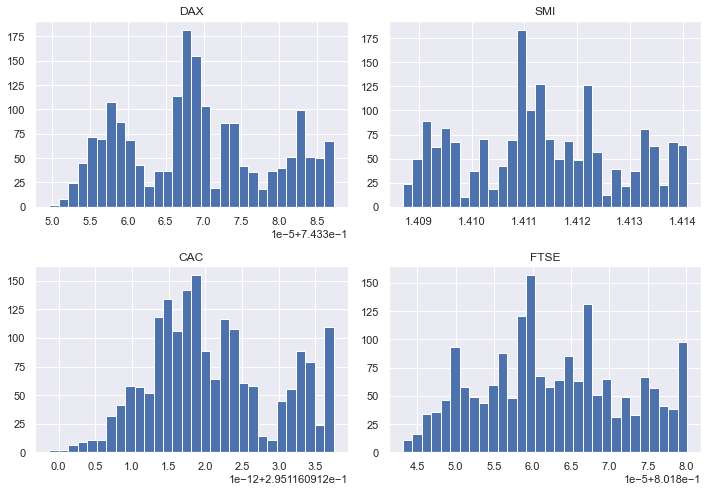

In [37]:
df_box_cox.hist(bins=30,figsize=(10,7))
plt.tight_layout()
plt.show;
# the extra numbers on some of the histograms are offsets.

## Additive Decomposition

First we estimate the Trend-Cycle, $\hat{T}$, using moving averages as we did above.

Secondly, we need to detrend the data, $y_t - \hat{T_t}$

Next step is to estimate the seasonal component, $\hat{S}_t$.
The seasonal component is estimated season-wise, i.e. we average the detrended values for each season, and then concatenate those estimates from different seasons.
Here, we'll consider the *month* as the season. 

The remainder/residual component:$\hat{R}_t = y_t - \hat{T}_t-\hat{S}_t$.

Fortunately, *statsmodels* module does all of this automatically for us.

Check this [online book](https://otexts.com/fpp3/classical-decomposition.html) for more information on the classical decomposition.

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
def creat_class_decomp(mkt_ind,model):
    class_decomp=pd.DataFrame()
    cl_dp=seasonal_decompose(df[mkt_ind], model=model)
    class_decomp[mkt_ind+" Trend-Cycle"]=cl_dp.trend
    class_decomp[mkt_ind+" Seasonal"]=cl_dp.seasonal
    class_decomp[mkt_ind+" Residual"]=cl_dp.resid
    return class_decomp

def plot_classical(mkt_ind,model="additive",time_length=50):
    
    class_decomp=creat_class_decomp(mkt_ind,model)
    
    print(class_decomp.describe())
    
    fig, axes = plt.subplots(4, 1, figsize=(12,12),sharex=True)
    
    # If we include the complete time series we can't see very well the differences.
    fig.suptitle('Classical '+model+ ' Decomposition: '+ mkt_ind)
    
    line1, = axes[0].plot(df[mkt_ind][-time_length:], label='Original Data')
    axes[0].legend(handles=[line1])
    
    line2, = axes[1].plot(class_decomp[mkt_ind+" Trend-Cycle"][-time_length:],
                          label='Trend-Cycle: ')
    axes[1].legend(handles=[line2])
    
    line3, = axes[2].plot(class_decomp[mkt_ind+" Seasonal"][-time_length:],
                          label='Seasonal: ')
    axes[2].legend(handles=[line3])
    
    line4, = axes[3].plot(class_decomp[mkt_ind+" Residual"][-time_length:],
                          label='Residual: ')
    axes[3].legend(handles=[line4])    
    axes[3].tick_params(axis="x", labelrotation=45)
    
    plt.tight_layout()
    plt.show;

       FTSE Trend-Cycle  FTSE Seasonal  FTSE Residual
count       1856.000000   1.860000e+03    1856.000000
mean        3564.825862   5.968941e-20       0.010867
std          974.713755   8.913718e-01      19.388741
min         2300.260000  -1.542835e+00    -100.877165
25%         2843.205000  -3.560423e-01     -10.345533
50%         3242.230000   3.237960e-01       0.606123
75%         3996.920000   5.444429e-01      10.986083
max         6150.800000   1.030638e+00      95.276042


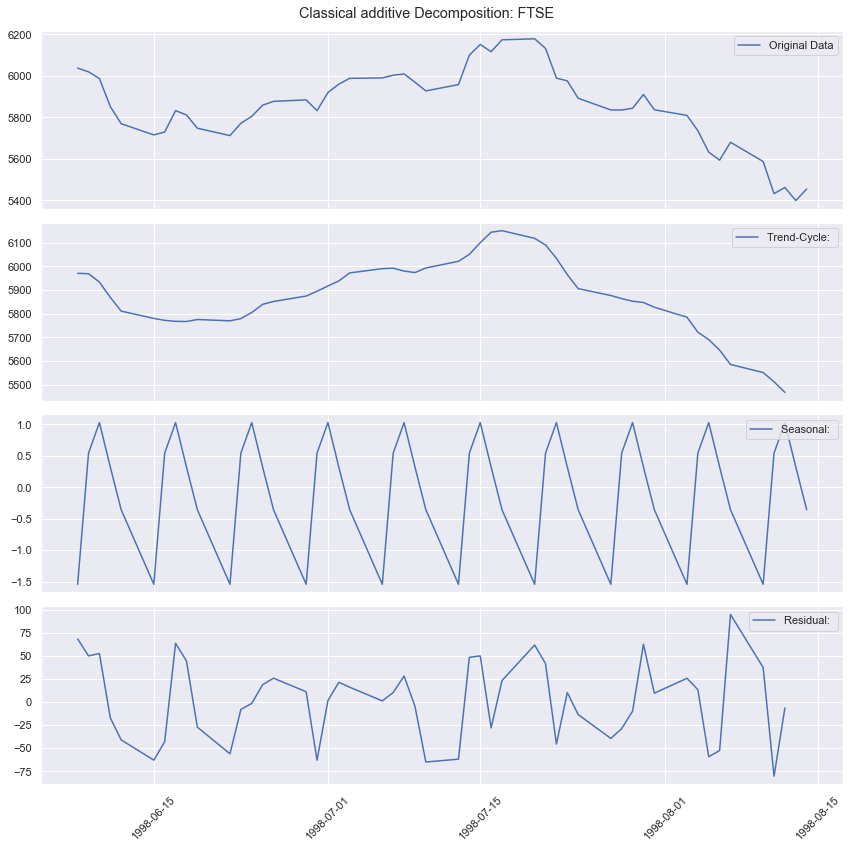

In [22]:
plot_classical("FTSE")

## Multiplicative Decomposition

Instead of subtracting, use division in the steps described above for the additive decomposition

       FTSE Trend-Cycle  FTSE Seasonal  FTSE Residual
count       1856.000000    1860.000000    1856.000000
mean        3564.825862       1.000000       0.999987
std          974.713755       0.000213       0.005041
min         2300.260000       0.999585       0.972884
25%         2843.205000       1.000024       0.996984
50%         3242.230000       1.000092       1.000197
75%         3996.920000       1.000134       1.003265
max         6150.800000       1.000165       1.021359


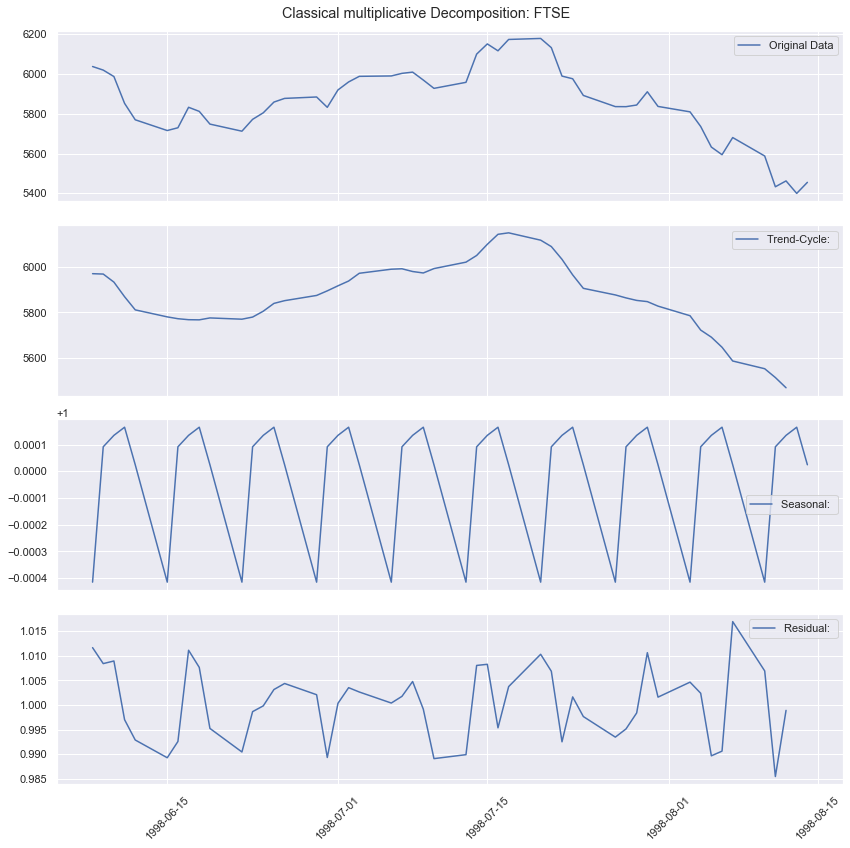

In [23]:
plot_classical("FTSE", model="multiplicative")

The additive and multiplicative graphs may look similar, but if you look at the y axis, you'll see some differences, namely on the seasonal and residual component.

## STL Decomposition (to be completed)

In [14]:
from statsmodels.tsa.seasonal import STL

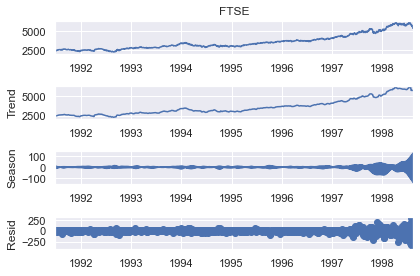

In [39]:
stl = STL(df["FTSE"], seasonal=13,robust=True)
res = stl.fit()
fig = res.plot()

# Testing our Models (Residual Testing)

How good is our model? One way to assess our model, is to analyse the resulting noise/residual. If there is *significant* correlation among them, then we may need to look for a more complex stationary time series model that could also explain away that relationship from the residuals.

Note: the residuals could have been obtained either by differencing the data,
or subtracting the fitted trend and seasonal components, or any other method.

In [83]:
cl_dmp=creat_class_decomp("FTSE",model="additive")

In [84]:
cl_dmp

,FTSE Trend-Cycle,FTSE Seasonal,FTSE Residual
1991-07-01,NaN,-1.542835,NaN
1991-07-02,NaN,0.544443,NaN
1991-07-03,2461.42,1.030638,-14.250638
1991-07-04,2466.06,0.323796,4.016204
1991-07-05,2471.60,-0.356042,13.456042
...,...,...,...
1998-08-10,5551.42,-1.542835,37.722835
1998-08-11,5512.50,0.544443,-80.244443
1998-08-12,5467.42,1.030638,-6.250638
1998-08-13,NaN,0.323796,NaN


## 1) Independence => no autocorrelation

In [85]:
from statsmodels.tsa.stattools import acf

In [86]:
residuals=cl_dmp["FTSE Residual"][cl_dmp["FTSE Residual"].isnull()==False]

In [87]:
residuals

1991-07-03   -14.250638
1991-07-04     4.016204
1991-07-05    13.456042
1991-07-08   -15.297165
1991-07-09    -4.304443
                ...    
1998-08-06   -52.363796
1998-08-07    95.276042
1998-08-10    37.722835
1998-08-11   -80.244443
1998-08-12    -6.250638
Freq: B, Name: FTSE Residual, Length: 1856, dtype: float64

In [88]:
auto_corr=acf(residuals,nlags=len(residuals)-1)

C:\Users\iavta\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


For large $n$, the sample autocorrelations of an iid sequence $Y_1,..., Y_n$ with finite variance are approximately iid with distribution $N(0, \frac{1}{n})$ (see Brockwell and Davis (1991) p. 222)
Hence, if $y_1,..., y_n$ is a realization of such an iid sequence, about 95 % of the sample autocorrelations should fall between the bounds +-$\frac{1.96}{sqrt{n}}$.

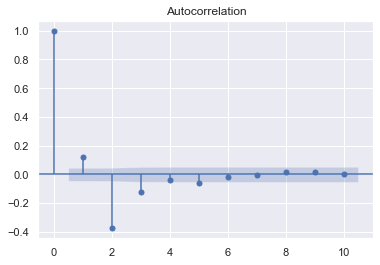

In [89]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(auto_corr, lags=10)
plt.show()


There seems to exist some correlation for at least the first 3 lags. We could improve our model.

### Portemanteau Test for autocorrelation (Ljung-Box test of autocorrelation in residuals)

In [90]:
from statsmodels.stats.diagnostic import acorr_ljungbox

The Null hypothesis in the Ljung-Box test is that (finite var iid sequence =>) the test statistic will follow a chi-squared distribution, with deg.freedom $=$ to size of the sequence. Hence, we reject this hypothesis when the test statistic is greater than the $1- \alpha $-quantile of the chi-squared distribution, i.e. p-value smaller than $\alpha$.
This test loses its properties as the number of considered lags increases.

Which lag should one choose for this test? Some say $log(n)$, others say up to $\frac{n}{5}$. 

Note: [Maybe it's better to do the Breusch-Godfrey test](https://stats.stackexchange.com/a/205262/40252)

In [91]:
n_lag=np.floor(np.log(len(residuals)))
ljung_box=acorr_ljungbox(residuals, lags=n_lag,return_df=True)
# If lags is an integer then this is taken to be the largest lag that is included,
# the test result is reported for all smaller lag length. 
# If lags is a list or array, then all lags are included up to the largest lag in the list,
# however only the tests for the lags in the list are reported.
ljung_box

,lb_stat,lb_pvalue
1,12.795536,3.474474e-04
2,294.931270,9.046665e-65
3,321.509505,2.197757e-69
4,325.678928,3.119880e-69
5,333.876944,5.171751e-70
6,335.097636,2.437304e-69
7,335.126405,1.877523e-68


 We always reject the null, since all the p-values are very small...

So far, the tests indicate that we should we improve our model, since there's still information to be explored.

## 2) Gaussian residuals

If the noise process is Gaussian, i.e., if all of its joint distributions are normal, then stronger conclusions can be drawn when a model is fitted to the data.

In [92]:
from statsmodels.graphics.gofplots import qqplot

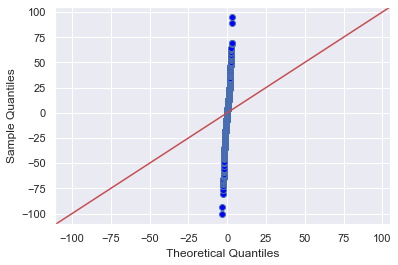

In [93]:
qqplot(residuals, line='45');

Cleary, since the sample quantiles are very different from the theoretical quantiles, we can state that the residuals are not from a normal distribution. See Brockwell for a formal test.